In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
font = {'family' : 'arial',
        'size'   : 14}

plt.rc('font', **font)

In [3]:
df = pd.read_csv('DNS_datastore.csv', index_col=0)

def add_noise_split(df):
    features = list(df.columns)[8:]

    x = np.array(df.loc[:,features].fillna(0))
    y = np.array(df['Label'])

    mu = 0
    sigma = (0.03 * x.mean(axis=0))
    noise = np.random.normal(mu, sigma, size=x.shape)

    x = x + noise
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = add_noise_split(df)

In [4]:
rf_test = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
    min_samples_leaf= 0.1,
    min_samples_split= 0.2,
    max_depth=3,
    n_jobs=-1,
    random_state=None)

In [5]:
def plot_search(p, name, score='accuracy', model=rf_test, x=x_train, y=y_train):
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=p, 
                               scoring=['accuracy','f1'],
                               return_train_score=True,
                               refit=False, 
                               cv=StratifiedKFold(n_splits=10, shuffle=True),
                               n_jobs=-1, verbose=0)
    grid_search.fit(x_train, y_train)
    

    param_name = 'param_%s' % list(p.keys())[0]

    # Extract information from the cross validation model
    train_means = grid_search.cv_results_['mean_train_'+score]*100
    train_stds  = grid_search.cv_results_['std_train_'+score]*100
    test_means  = grid_search.cv_results_['mean_test_'+score]*100
    test_stds   = grid_search.cv_results_['std_test_'+score]*100
    time_means  = grid_search.cv_results_['mean_fit_time']
    time_stds   = grid_search.cv_results_['std_fit_time']
    
    param_values = list(grid_search.cv_results_[param_name])
    
    # Plot the means over the parameter
    plt.subplots(1, 2, figsize=(18, 8))
    plt.subplot(121)
    plt.plot(param_values, train_means, 'b-', label = 'train')
    plt.fill_between(param_values, train_means-train_stds, train_means+train_stds, alpha=0.3, color='b')
    plt.plot(param_values, test_means, 'g-', label = 'test')
    plt.fill_between(param_values, test_means-test_stds, test_means+test_stds, alpha=0.3, color='g')
    
    #plt.ylim(ymin = 0.94, ymax = 1)
    plt.autoscale()
    plt.legend()
    plt.xlabel(name)
    plt.ylabel(score+' (%)')
    plt.title('%s vs %s' % (score,name))
    
    plt.subplot(122)
    plt.plot(param_values, time_means, 'r-')
    plt.fill_between(param_values, time_means-time_stds, time_means+time_stds, alpha=0.2, color='r')
    plt.ylim(ymin = 0.0, ymax = max(list(time_means+time_stds)))
    plt.xlabel(name)
    plt.ylabel('train time (sec)')
    plt.title('training time vs %s' % name)
    
    #return grid_search.cv_results_
    

Wall time: 1min 15s


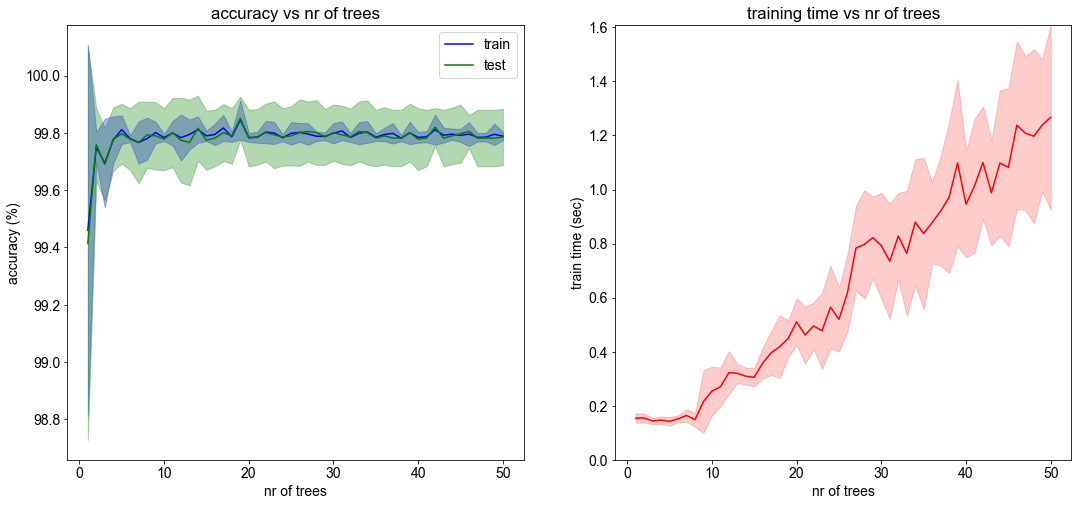

In [6]:
%%time
plot_search({'n_estimators':range(1,51)}, 'nr of trees')

Wall time: 3min 24s


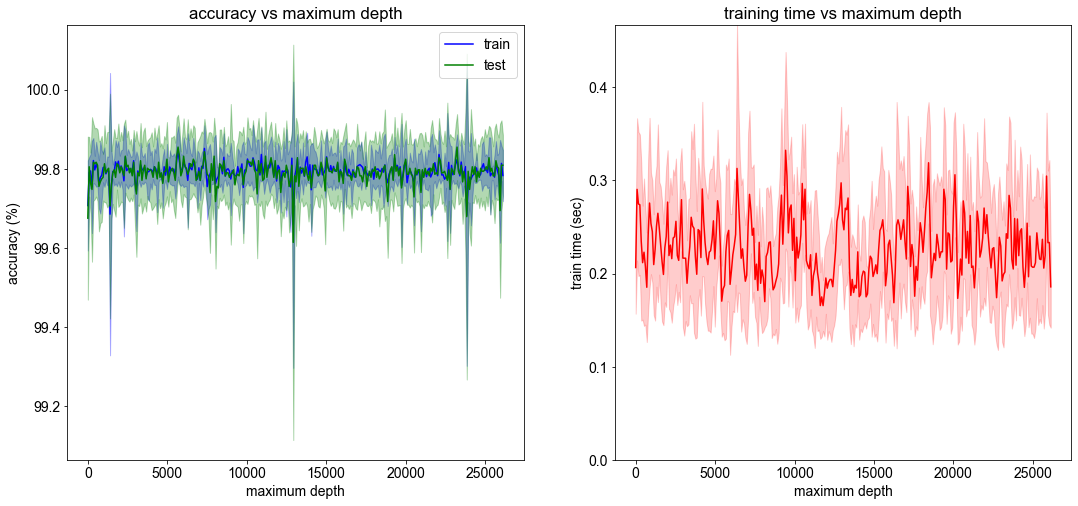

In [7]:
%%time
plot_search({'max_depth':np.linspace(1,x_train.shape[0]-1,300)}, 'maximum depth')

In [ ]:
%%time
plot_search({'max_features': list(range(1, x_train.shape[1] + 1))}, 'maximum features')

In [ ]:
%%time
plot_search({'min_samples_leaf': range(int(x_train.shape[0]/2))}, 'minimum samples per leaf node')

In [ ]:
%%time
plot_search({'min_samples_split': range(int(x_train.shape[0]/2))}, 'minimum samples per splitting node')

In [ ]:
int(x_train.shape[0]/2)

In [ ]:
# decreasing the difference between benign and malicious data to anticipate future attacks,
# in which the attack may be harder to find

def worsen(df,times):
    for i in range(times):
        df.iloc[:,9:] = (df.iloc[:,9:]+df.iloc[:,9:].mean(axis=0))/2
    return df

In [ ]:
df3 = worsen(df,3)
x_train, x_test, y_train, y_test = add_noise_split(df3)

In [ ]:
%%time
plot_search({'n_estimators':range(1,51)}, 'nr of trees')